In [1]:
require(ecipex)
require(tidyverse)
require(stringr)
require(broom)
require(readxl)

setwd('~/stanford/experiments/exp_134')

Loading required package: ecipex
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: broom
Loading required package: readxl


# Overview

This notebook shows how to turn mass isotopologue distribution data for a metabolite into a single number describing the heavy label content of the metabolite in _three_ different ways.  

1. No assumptions: calculate total D content by mass balance.  (Really, there is one assumption: you know the structure of your metabolite and how many solvent-exchangeable hydrogens it has, but that's it.)

2. Single-degree-of-freedom model.  Assume that all (non-exchangeable) hydrogens in your metabolite have the same, unknown probability of being labeled.  Estimate the single labeling probability from the data.

3. Two-component mixture model.  Assume that your MID results from mixing two distinct pools of metabolite: one with one (specified) MID and one with another (specified) MID.  Determine the relative ratio of these two pools from your experimental MID.  

The data shown here was generated by Ryan Nett in 2018, and thus this notebook uses huperzine A as an example metabolite.  The data is not supplied with the notebook.  It is time-course data obtained by growing a plant in isotopically labeled media and taking samples of metabolites over time.  The data consists of ion counts for the `M0`, `M1`, `M2`, etc. peaks for a compound that was of interest to Ryan.

The notebook makes no attempt to use portable filepath or directory naming conventions.  You'll need to tweak filenames and directory names for your local environment if you ever try to use it.

## First approach
First, using no assumptions, the "neutron excess" or NE is calculated from an MID.  This doesn't depend on any assumptions about the distribution of these excess neutrons in a molecule.  It is just calculated from

$$\mathrm{NE}=\frac{\sum_{i=0}^n i\;M_i}{n}$$

where $n$ is the number of (integer) mass isotopologues that a moleclue has, and $M_i$ the relative abundance of the $i$th isotopologue.  Some examples:  
1. If a molecule with 12 label-able positions (i.e. $n$ = 12) were completely deuterated, it would have zero abundance for $M_0$, $M_1$, $M_3$, ..., $M_{11}$, and abundance 1 for $M_{12}$, so the neutron excess would be $\frac{12 * 1}{12}=1$.
2. If a molecule with 12 label-able positions had no intensity for $M_0$, $M_1$, $M_3$, ..., $M_{10}$, had an intensity 1 for $M_{11}$, and no intensity at all for $M_{12}$, the neutron excess would be $\frac{11 * 1}{12}\approx 0.91$
3. If a molecule with 12 label-able positions had equal intensities for all peaks, i.e. $M_0=M_1=...=M_{12}=\frac{1}{13}$, then the neutron excess would be 0.5.  This would also be the neutron abundance for an MID with $M_0=M_{12}=0.5$ and $M_1=M_2=...=M_{11}=0$.

We can correct the neutron abundance for the predicted natural abundance of neutrons in an MID.  Here this corrected value is the "differential neutron excess" or $\Delta \mathrm{NE}=\mathrm{NE} - \mathrm{NE}_{natural}$  These natural abundance estimates aren't perfect because there isn't really a single value for "natural", and much more importantly, mass spectrometers imprecisely measure MIDs because of truncation effects.  Weak peaks will be systematically weakened, and strong peaks systematically strengthened, because of signal-to-noise issues and signal processing artifacts.  

## huperzine A definitions

In [2]:
HUP_A <- 'C15H18N2O'
HUP_A_DEUT <- 'C15H3Ir15N2O'

## simulate a 2nd class of hydrogens

In [3]:
h_masses <- nistiso[nistiso$element=='H', 'mass']
h_masses

d_abund <- 0.10 

[1] 1.007825 2.014102

In [4]:
# redefine iridium as an independent H mass
my_iso <- nistiso
my_iso[my_iso$element == 'Ir', 'mass'] <- h_masses
my_iso[my_iso$element == 'Ir', 'nucleons'] <- c(1, 2)
my_iso[my_iso$element == 'Ir', 'abundance'] <- c(1-d_abund, d_abund)


## load data

In [5]:
ryan.data <- read_excel('from_ryan/180131_RSN_D2O_experiment.xlsx') 

masses <- names(ryan.data) %>% as.numeric

mid.data <- ryan.data %>% 
    setNames(c('group', 'M0', 'M1', 'M2', 'unk')) %>%
    group_by(group) %>%
    gather(ion, intensity, -group) %>%
    mutate(timepoint = str_extract(group, '(?<=t)[0-9]{1,2}') %>% as.numeric,
           replicate = str_extract(group, '(?<=-)[0-9]$') %>% as.numeric) %>%
    filter(ion != 'unk') %>%
    ungroup %>%
    select(-group) %>%
    group_by(timepoint, replicate) %>%
    mutate(mid = intensity / sum(intensity)) %>%
    select(timepoint, replicate, ion, mid) %>%
    arrange(timepoint, replicate, ion) 

mid.data

Warning message in function_list[[k]](value):
“NAs introduced by coercion”

timepoint,replicate,ion,mid
0,1,M0,0.84524428
0,1,M1,0.14310673
0,1,M2,0.01164899
0,2,M0,0.84766594
0,2,M1,0.14077012
0,2,M2,0.01156395
0,3,M0,0.84820745
0,3,M1,0.13932347
0,3,M2,0.01246909
3,1,M0,0.84325891


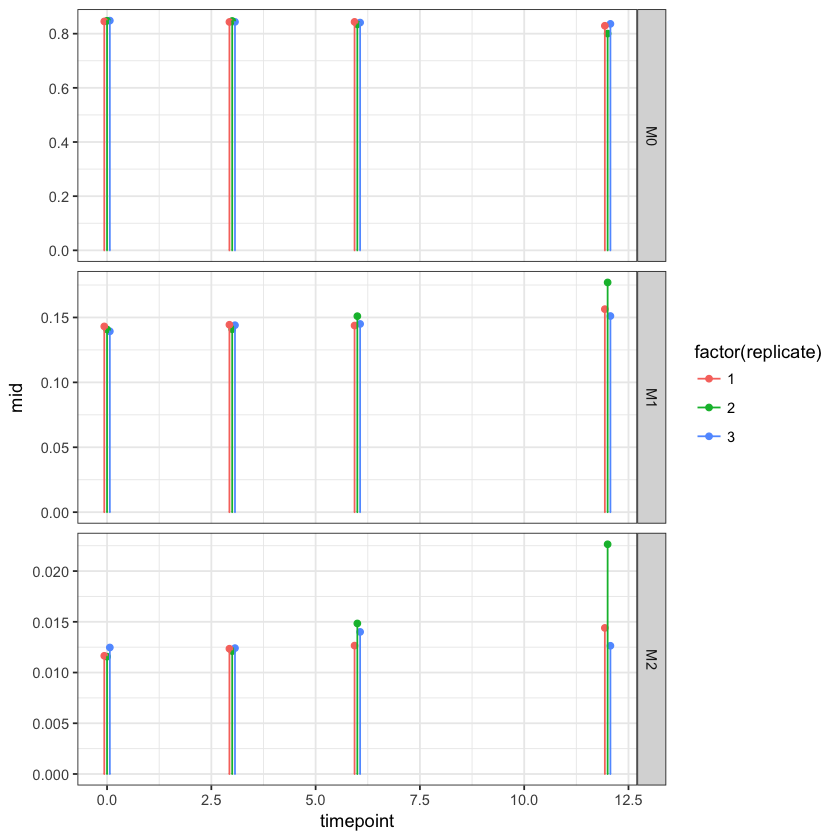

In [6]:
mid.data %>% 
    ggplot(aes(x=timepoint, y=mid, color=factor(replicate), ymin=0, ymax=mid)) +
        geom_point(position = position_dodge(width=0.2)) +
        geom_errorbar(width=0.1, position=position_dodge(width=0.2)) +
        facet_grid(ion ~ ., scale='free_y') +
        theme_bw()

In [7]:
mid.data %>% 
    spread(ion, mid) %>%
    mutate(neutron_abund = 0*M0 + 1*M1 + 2*M2) %>%
    group_by(replicate) %>%
    do(tidy(lm(data=., formula=neutron_abund~timepoint)))

replicate,term,estimate,std.error,statistic,p.value
1,(Intercept),0.1642563490,0.0030045584,54.669049,3.344253e-04
1,timepoint,0.0015596793,0.0004370989,3.568252,7.035220e-02
2,(Intercept),0.1560762744,0.0069465334,22.468225,1.975033e-03
2,timepoint,0.0051264188,0.0010105719,5.072790,3.673251e-02
3,(Intercept),0.1654223976,0.0012361572,133.819874,5.583704e-05
3,timepoint,0.0009916091,0.0001798344,5.514012,3.135153e-02


#### calc MIDs

In [8]:
my_formulae <- list(HUP_A, HUP_A_DEUT)

mids <- ecipex(my_formulae, isoinfo = my_iso, id = T, limit=1e-6)

for(df_name in names(mids)){
    mids[[df_name]]$formula <- df_name
}

all_mids <- bind_rows(mids)

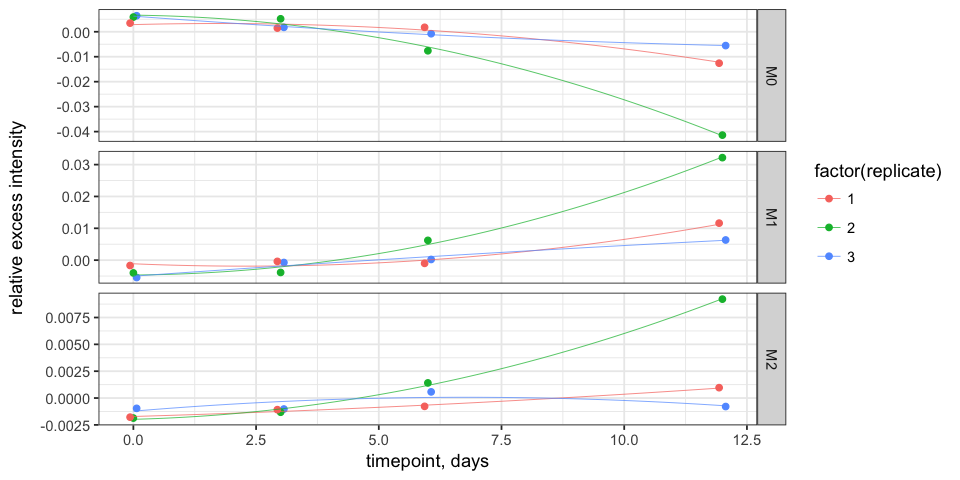

In [9]:
options(repr.plot.height=4, repr.plot.width=8)

all_mid_annot <- all_mids %>% 
    mutate(int_mass = round(mass, 0)) %>%
    group_by(formula, int_mass) %>%
    summarize(total_abund = sum(abundance), mass = sum(mass*abundance)/sum(abundance)) %>%
    group_by(int_mass) %>%
    arrange(int_mass) %>%
    mutate(ppm = (mass - min(mass))/(0.5*(mass + min(mass)))*1e6)

with.theoretical <- all_mid_annot %>%
    filter(formula == 'C15H18N2O') %>%
    ungroup %>%
    mutate(ion = paste0('M', (int_mass-min(int_mass))), sep='') %>%
    filter(ion %in% c('M0', 'M1', 'M2')) %>%
    mutate(theoretical_mid = total_abund / sum(total_abund)) %>%
    select(ion, theoretical_mid) %>%
    left_join(mid.data, by=c('ion')) %>%
    rename(experimental_mid = mid) %>%
    group_by(ion, timepoint, replicate) %>%
    mutate(diff = experimental_mid - theoretical_mid)

with.theoretical %>%
    ggplot(aes(x=timepoint%>%as.numeric, 
               y=diff, color=factor(replicate), 
               ymin=0, ymax=diff)) +
        geom_point(position = position_dodge(width=0.2)) +
        #geom_errorbar(width=0.1, position=position_dodge(width=0.2)) +
        facet_grid(ion ~ ., scale='free_y') +
        theme_bw() +
        ylab('relative excess intensity') +
        stat_smooth(method=lm, formula=y~poly(x,2), se=F, size=0.2) +
        xlab('timepoint, days')

Saving 7 x 7 in image


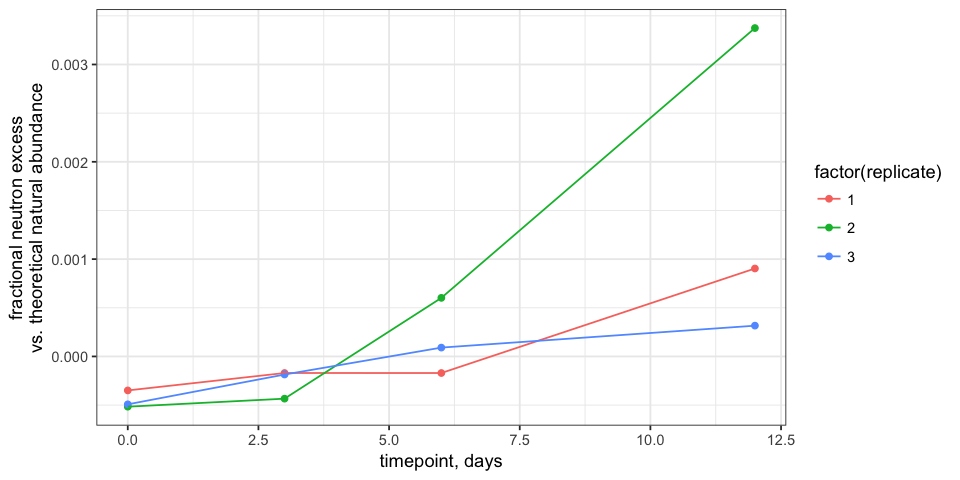

In [10]:
with.theoretical %>%
    select(-experimental_mid, -theoretical_mid) %>%
    spread(ion, diff) %>%
    mutate(neutron_excess = (0*M0 + 1*M1 + 2*M2)/15) %>%  #15 is number of non-exchangeable deuteriums in hupA
    ggplot(aes(x=timepoint%>% as.numeric,
               y = neutron_excess, 
               color=factor(replicate))) +
        geom_point() +
        geom_line() +
        theme_bw() +
        ylab('fractional neutron excess\nvs. theoretical natural abundance') +
        xlab('timepoint, days')

ggsave('graphs/ryans_data_timecourse.pdf')

## Second approach
Second, we assume that all _non-exchangeable_ positions in a molecule are equally likely to be deuterated with an unknown probability, and use fitting routines to estimate the probability.  This is a "single-degree of freedom" model.  

This approach should _fail_ or at least give misleading results for the step-change label experiment.  We expect two distinct pools of material: (ii) unlabeled material where the probability of a deuterium is the natural abundance of deuterium ($\approx$ 156 ppm), and (ii) labeled material where the probability of a deuterium is 10%.

In [11]:
predict_mid <- function(formula, abund, m_keeps=NULL){
    # configure isotope info
    my_iso <- nistiso
    
    # assume H is the isotopically labeled element; use Ir to represent label-able Hs
    h_masses <- nistiso[nistiso$element=='H', 'mass']
    my_iso[my_iso$element == 'Ir', 'mass'] <- h_masses
    my_iso[my_iso$element == 'Ir', 'nucleons'] <- c(1, 2)
    my_iso[my_iso$element == 'Ir', 'abundance'] <- c(1-abund, abund)
    
    # find default m_keeps
    if(is.null(m_keeps)){
        range <- ecipex(formula, isoinfo=my_iso)[[1]]$mass %>% round(0)
        m_keeps <- (range - min(range)) %>% unique
    }
    
    # get MID
    res1 <- ecipex(formula, 
                  isoinfo=my_iso,                 
                  sortby='abund'
                 )[[1]] %>%
           mutate(int_mass = round(mass, 0)) %>%
           mutate(m = int_mass - min(int_mass)) %>%
           group_by(m) %>%
           summarize(abundance = sum(abundance))
    res2 <- res1 %>%
           filter(m %in% m_keeps) %>% 
           mutate(abundance = abundance/sum(abundance)) %>%  # renormalize
           pull(abundance)
    return(res2)
}

In [12]:
mid.data.prepped <- 
    mid.data %>% 
        group_by(timepoint, replicate) %>%
        mutate(m = str_extract(ion, '(?<=M)[0-9]*$') %>% as.numeric)

fit <- mid.data.prepped %>%
        do(augment(nls(data=.,
            formula=mid ~ predict_mid(HUP_A_DEUT, abund, m_keeps = c(0, 1, 2)),
            start = list(abund=0.1),
            lower = c(0),
            upper = c(1),
            algorithm="port",
            control=nls.control(warnOnly=T)
                   )
               )
          )

Warning message in nls(data = ., formula = mid ~ predict_mid(HUP_A_DEUT, abund, :
“Convergence failure: false convergence (8)”

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

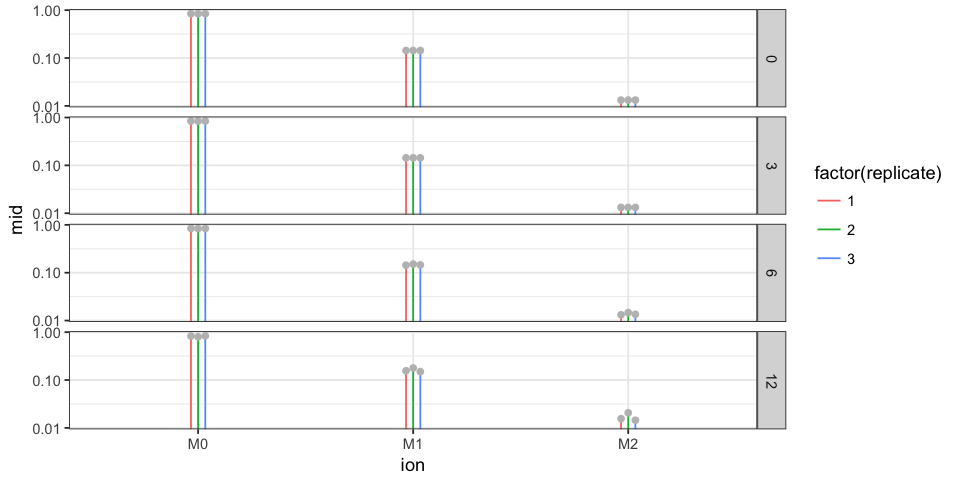

In [13]:
fit %>% 
    left_join(mid.data.prepped, by=c('timepoint', 'replicate', 'mid')) %>%
    ggplot(aes(x=ion, y=mid, ymin=0, ymax=mid, color=factor(replicate))) +
        geom_errorbar(position=position_dodge(width=0.1), width=0) +
        geom_point(position=position_dodge(width=0.1), color='gray', aes(x=ion, y=.fitted, group=factor(replicate))) +
        facet_grid(timepoint ~ .) +
        theme_bw() +
        scale_y_log10()

In [14]:
fit_results <- mid.data.prepped %>%
        do(tidy(nls(data=.,
            formula=mid ~ predict_mid(HUP_A_DEUT, abund, m_keeps = c(0, 1, 2)),
            start = list(abund=0.1),
            lower = c(0),
            upper = c(1),
            algorithm="port",
            control=nls.control(warnOnly=T)
                   )
               )
          )

Warning message in nls(data = ., formula = mid ~ predict_mid(HUP_A_DEUT, abund, :
“Convergence failure: false convergence (8)”

In [15]:
fit_results

timepoint,replicate,term,estimate,std.error,statistic,p.value
0,1,abund,0.000000e+00,1.115762e-04,0.0000000,1.000000000
0,2,abund,0.000000e+00,2.367590e-04,0.0000000,1.000000000
0,3,abund,0.000000e+00,2.835410e-04,0.0000000,1.000000000
3,1,abund,2.391453e-05,4.811990e-05,0.4969779,0.668459321
3,2,abund,0.000000e+00,2.031995e-04,0.0000000,1.000000000
3,3,abund,0.000000e+00,4.224533e-05,0.0000000,1.000000000
6,1,abund,0.000000e+00,2.926523e-05,0.0000000,1.000000000
6,2,abund,7.240637e-04,9.979850e-06,72.5525592,0.000189920
6,3,abund,1.641833e-04,2.543314e-05,6.4554845,0.023165618
12,1,abund,1.168008e-03,6.426671e-05,18.1743851,0.003013795


Saving 7 x 7 in image


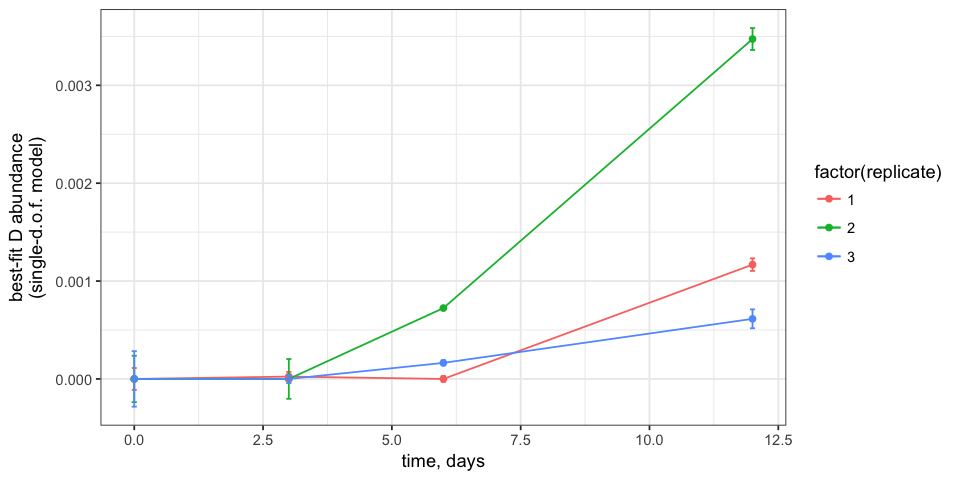

In [16]:
fit_results %>%
    ggplot(aes(x=timepoint, 
               y=estimate, 
               ymin=estimate - std.error,
               ymax=estimate + std.error,
               color=factor(replicate))) +
        geom_point() + 
        geom_line() +
        geom_errorbar(width=0.1) +
        xlab('time, days') +
        ylab('best-fit D abundance\n(single-d.o.f. model)') +
        theme_bw()

ggsave('graphs/ryans_data_timecourse_best_fit.pdf')

## Third approach: a mixture model

This approach assumes the data arises from a mixture of two distinct species: one that has natural abundance, and one that has 10% of the non-exchangeable H positions substituted by D.  The relative ratios of the two species are not known and will be determined by the data.  Note that this approach assumes that HupA will eventually become as labeled as the D2O it is grown in (here, assumed to be 10%).  This is equivalent to neglecting all isotopic fractionation.

In [17]:
get_mid_from_formula <- function(formula, this_isoinfo, name){
    ecipex(formula, id = T, limit = 1e-6, sortby = 'mass', isoinfo = this_isoinfo)[[1]] %>%
        mutate(ion_mass = mass + 1.0072) %>%
        mutate(int_mass = round(ion_mass, 0)) %>%
        group_by(int_mass) %>% 
        summarize(abundance = sum(abundance), ion_mass = mean(ion_mass * abundance) / mean(abundance)) %>%
        mutate(molecule = name) %>%
        mutate(ion = paste0('M', (int_mass - min(int_mass)), sep=''),
        m = str_extract(ion, '(?<=M)[0-9]{1,2}') %>% as.numeric) %>%
        select(name=molecule, m, mid=abundance)
}


In [18]:
labeled_data <- get_mid_from_formula(HUP_A_DEUT, my_iso, 'labeled')
natural_data <- get_mid_from_formula(HUP_A, nistiso, 'natural_abund')

In [19]:
theo_data <-
    labeled_data %>%
    left_join(natural_data, by='m') %>%
    setNames(c('foo', 'm', 'labeled_mid', 'goo', 'natural_mid')) %>%
    select(-foo, -goo) %>%
    filter(m <= 4) 

In [20]:
mid.data.prepped %>% left_join(theo_data, by='m') %>% head

timepoint,replicate,ion,mid,m,labeled_mid,natural_mid
0,1,M0,0.84524428,0,0.1734538,0.84100203
0,1,M1,0.14310673,1,0.3186234,0.14464704
0,1,M2,0.01164899,2,0.2767857,0.01341754
0,2,M0,0.84766594,0,0.1734538,0.84100203
0,2,M1,0.14077012,1,0.3186234,0.14464704
0,2,M2,0.01156395,2,0.2767857,0.01341754


In [21]:
mid.data.prepped %>% head

timepoint,replicate,ion,mid,m
0,1,M0,0.84524428,0
0,1,M1,0.14310673,1
0,1,M2,0.01164899,2
0,2,M0,0.84766594,0
0,2,M1,0.14077012,1
0,2,M2,0.01156395,2


timepoint,replicate,sigma,isConv,finTol,logLik,AIC,BIC,deviance,df.residual
0,1,2.994919e-04,TRUE,4.359943e-07,20.691652,-37.38330,-39.18608,1.793908e-07,2
0,2,1.601555e-03,TRUE,5.633340e-06,15.661723,-27.32345,-29.12622,5.129955e-06,2
0,3,2.778727e-03,TRUE,3.376272e-06,14.008669,-24.01734,-25.82011,1.544265e-05,2
3,1,2.676691e-04,TRUE,2.732307e-07,21.028659,-38.05732,-39.86009,1.432935e-07,2
3,2,1.702343e-03,TRUE,5.189653e-06,15.478631,-26.95726,-28.76004,5.795943e-06,2
3,3,4.151718e-05,TRUE,1.073245e-07,26.619592,-49.23918,-51.04196,3.447352e-09,2
6,1,2.259018e-04,TRUE,4.769029e-07,21.537613,-39.07523,-40.87800,1.020632e-07,2
6,2,3.323198e-03,TRUE,2.150758e-06,13.471865,-22.94373,-24.74651,2.208729e-05,2
6,3,4.357337e-04,TRUE,5.037544e-06,19.566820,-35.13364,-36.93642,3.797277e-07,2
12,1,6.646558e-03,TRUE,1.033280e-06,11.392350,-18.78470,-20.58748,8.835348e-05,2


timepoint,replicate,term,estimate,std.error,statistic,p.value
0,1,f,-0.0065394954,4.055895e-04,-16.1234326,0.0038246165
0,2,f,-0.0102909274,2.168922e-03,-4.7447200,0.0416636632
0,3,f,-0.0109782868,3.763120e-03,-2.9173361,0.1001553295
3,1,f,-0.0033606874,3.624931e-04,-9.2710390,0.0114351988
3,2,f,-0.0091316684,2.305414e-03,-3.9609675,0.0582266370
3,3,f,-0.0038015892,5.622503e-05,-67.6138229,0.0002186687
6,1,f,-0.0037885751,3.059289e-04,-12.3838414,0.0064575327
6,2,f,0.0110785128,4.500468e-03,2.4616357,0.1329069932
6,3,f,0.0003997284,5.901003e-04,0.6773906,0.5680112499
12,1,f,0.0186751402,9.001160e-03,2.0747481,0.1737008486


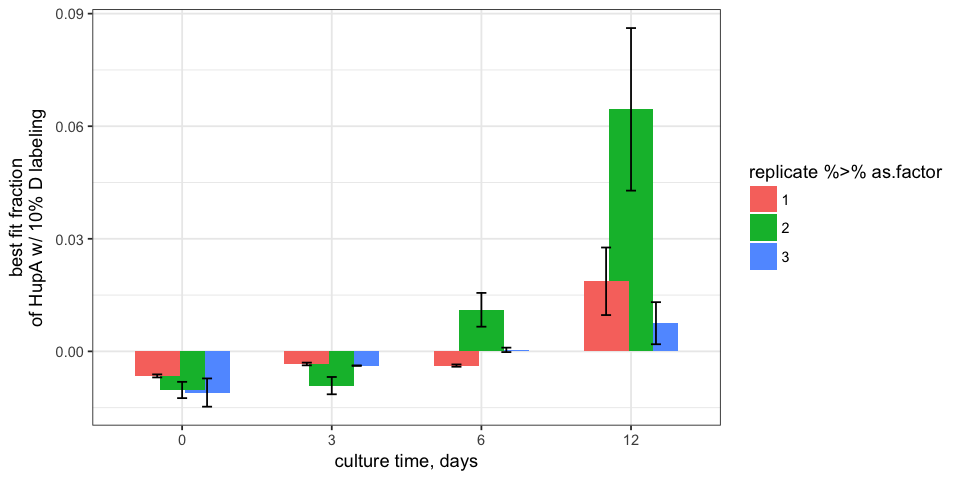

In [22]:
model.dat <- 
    mid.data.prepped %>% 
    left_join(theo_data, by='m') %>%
    group_by(timepoint, replicate)

model <- 
    model.dat %>%
    do(tidy(nls(data = ., formula = mid ~ f*labeled_mid + (1-f)*natural_mid, start = list(f = 0.1))))

model.glance <-
    model.dat %>%
    do(glance(nls(data = ., formula = mid ~ f*labeled_mid + (1-f)*natural_mid, start = list(f = 0.1))))

model.glance
model

model %>%
    ggplot(aes(x=timepoint%>%as.factor, fill=replicate%>%as.factor, y=estimate, ymin = estimate-std.error, ymax=estimate+std.error)) +
        geom_bar(stat='identity', position=position_dodge(0.5)) +
        geom_errorbar(width=0.2, position=position_dodge(0.5)) +
        ylab('best fit fraction\nof HupA w/ 10% D labeling') +
        xlab('culture time, days') +
        theme_bw()

All fits converged, although this modeling is somewhat strained because we aren't including any information on M3, M4, etc. in the fit, and it really should be there for more accurate fitting.  

Unlike some of the other models we've considered, this the $y$ axis here should reach 1.0 after complete labeling.  The best-case scenario is that huperzine A is 6% labeled at 12 days, and 1.2% labeled at 6 days, meaning 4.8% of complete labeling happens in 6 days.  The estimate turnover time for the pool, assuming it is constant in size, is thus 

$A = 1 - A_0 \exp{-t/\tau}$

$\frac{1 - A}{A_0} = \exp{-t/\tau}$

$\ln{\frac{1 - A}{A_0}} = -t/\tau$

$-\frac{1}{t}\ln{\frac{1 - A}{A_0}} = 1/\tau$

$t\ln{\frac{1-A}{A_0}} = \tau$

$6\ln{\frac{0.012}{1-0.06}}$

In [23]:
6 * log((1-0.06)/0.012)

[1] 26.16584

This single-point estimate of the turnover time is 26 days.  That means for nearly complete labeling, it would take 78 days (three turnovers).  The label dynamics at the early time points are inconsistent with this model.  The model assumes that biology doesn't change at $t_0$ when isotopic labeling is turned on, only that isotope abundances change then.  Cutting the plant and putting the shoots in a new environment probably perturbs the biology.  It is unlikely that we really have a metabolic steady state, and thus real experimental data probably do not reflect simple turnover (via de novo biosynthesis and dilution by growth) of a single pool.